In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

import wrangle as w

In [2]:
df = pd.read_csv('strike_reports.csv', encoding='latin1')

In [3]:
df.sample(2)

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,ENROUTE_STATE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
119580,739071,11/1/2012 0:00:00,11,2012,NaN,NaN,KILM,WILMINGTON INTL,34.27061,-77.90256,...,NaN,NaN,NaN,2012-11-1-152553 /Legacy Record=330258/,REDACTED,REDACTED,FAA Form 5200-7-E,Carcass Found,1/31/2013 0:00:00,0
264710,1347399,7/17/2022 0:00:00,7,2022,10:30,Day,KOMA,EPPLEY AIRFIELD,41.30252,-95.89417,...,NaN,NaN,NaN,*** Strike Report: 2022-07-22-161515-R1( Repor...,REDACTED,REDACTED,Multiple,Tower,12/5/2022 0:00:00,0


In [4]:
# make column names lowercase
df.columns = df.columns.str.lower()

In [5]:
# make the date column a datetime and set it as index (Takes about 7 seconds)
df = df.rename(columns={'incident_date' : 'date'})

# tried to make datetime conversion faster, but I ran into problems and it really wasn't that slow
# df.date = df.date.str.rstrip('0:00:00')
df.date = df.date.astype('datetime64')
df = df.set_index('date')
df = df.sort_index()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 279947 entries, 1990-01-02 to 2023-05-17
Data columns (total 99 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index_nr               279947 non-null  int64  
 1   incident_month         279947 non-null  int64  
 2   incident_year          279947 non-null  int64  
 3   time                   156370 non-null  object 
 4   time_of_day            162273 non-null  object 
 5   airport_id             279942 non-null  object 
 6   airport                279947 non-null  object 
 7   latitude               245560 non-null  float64
 8   longitude              245561 non-null  float64
 9   runway                 212020 non-null  object 
 10  state                  245563 non-null  object 
 11  faaregion              245563 non-null  object 
 12  location               32868 non-null   object 
 13  opid                   279943 non-null  object 
 14  operator            

In [7]:
# confirm the month and year columns are the same as the index datetime
df[df.index.month != df.incident_month]

,index_nr,incident_month,incident_year,time,time_of_day,airport_id,airport,latitude,longitude,runway,...,enroute_state,nr_injuries,nr_fatalities,comments,reported_name,reported_title,source,person,lupdate,transfer
date,,,,,,,,,,,,,,,,,,,,,


In [8]:
df[df.index.year != df.incident_year]

,index_nr,incident_month,incident_year,time,time_of_day,airport_id,airport,latitude,longitude,runway,...,enroute_state,nr_injuries,nr_fatalities,comments,reported_name,reported_title,source,person,lupdate,transfer
date,,,,,,,,,,,,,,,,,,,,,


In [9]:
# confirm all the nulls for state are the same as the nulls for faaregion
df[(df.state.isnull()) & (df.faaregion.isnull())].shape

(34384, 99)

In [10]:
# state is null if airport_id is 'ZZZZ', 
# AND there are 82 additional rows where state is null and airport_id is NOT 'ZZZZ'
df[(df.state.isnull()) & (df.airport_id != 'ZZZZ')]

,index_nr,incident_month,incident_year,time,time_of_day,airport_id,airport,latitude,longitude,runway,...,enroute_state,nr_injuries,nr_fatalities,comments,reported_name,reported_title,source,person,lupdate,transfer
date,,,,,,,,,,,,,,,,,,,,,
1990-03-31,637715,3,1990,17:30,NaN,PVT,PRIVATE AIR STRIP,NaN,NaN,NaN,...,NaN,NaN,NaN,NTSB LAX90LA151 STRIKE WAS DELETED BY ERROR BT...,REDACTED,REDACTED,NTSB,Other,5/18/2015 0:00:00,0
1990-08-10,1083895,8,1990,NaN,Day,H2O,REMOTE_WATER,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7,NaN,1/11/2021 0:00:00,0
1991-12-21,612244,12,1991,NaN,Day,RIGG,OIL RIG,NaN,NaN,NaN,...,NaN,NaN,NaN,/Legacy Record=104010/,REDACTED,REDACTED,FAA Form 5200-7,Pilot,4/1/1997 0:00:00,0
1992-05-30,637035,5,1992,NaN,NaN,PVT,PRIVATE AIR STRIP,NaN,NaN,NaN,...,NaN,NaN,NaN,(UPDATED LOCATION) /Legacy Record=128886/,REDACTED,REDACTED,NTSB,Other,5/18/2015 0:00:00,0
1993-09-20,636076,9,1993,09:45,Day,PVT,PRIVATE AIR STRIP,NaN,NaN,NaN,...,NaN,NaN,NaN,"SOURCE = 5200-7, NTSB SEA93LA203 & AAIPN OPER...",REDACTED,REDACTED,Multiple,Pilot,5/18/2015 0:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-10,1406874,1,2023,07:37,Dawn,NaN,JOHN GLENN COLUMBUS INTL ARPT - OH,NaN,NaN,28L,...,NaN,NaN,NaN,*** Strike Report: 2023-01-10-095944-R1( Repor...,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,3/7/2023 0:00:00,0
2023-02-06,1408363,2,2023,02:30,Night,NaN,"Lanett, AL",NaN,NaN,06,...,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Air Transport Operations,3/16/2023 0:00:00,0
2023-02-14,1408923,2,2023,21:02,NaN,NaN,UNKNOWN/REMOTE,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,3/22/2023 0:00:00,0


In [11]:
for col in df.columns:
    print(f'Value Counts for {col}')
    print(df[col].value_counts())
    print(f'Num of nulls: {df[col].isnull().sum()}')
    print(f'Num of NON-nulls: {df[col].notnull().sum()}')
    print()

Value Counts for index_nr
1242675    1
793126     1
792678     1
792677     1
1091244    1
          ..
698690     1
700415     1
697820     1
698691     1
1427626    1
Name: index_nr, Length: 279947, dtype: int64
Num of nulls: 0
Num of NON-nulls: 279947

Value Counts for incident_month
8     39029
9     37479
7     35234
10    35116
5     26804
6     22884
4     20556
11    19292
3     13983
12    11078
1      9430
2      9062
Name: incident_month, dtype: int64
Num of nulls: 0
Num of NON-nulls: 279947

Value Counts for incident_year
2019    17342
2022    17203
2018    16205
2021    15643
2017    14777
2015    13773
2014    13692
2016    13327
2020    11624
2013    11410
2012    10932
2011    10111
2010     9897
2009     9504
2007     7740
2008     7627
2006     7273
2005     7243
2004     6566
2002     6217
2000     6025
2003     5989
2001     5822
1999     5120
1998     3809
1997     3559
2023     3042
1996     3031
1995     2825
1994     2708
1992     2651
1993     2624
1991     251

In [12]:
# decide which columns to keep
keep_cols = ['time_of_day', 'airport_id', 'airport', 'runway', 'state', 'opid', 'operator'
             , 'aircraft', 'ac_class', 'ac_mass', 'type_eng', 'num_engs', 'phase_of_flight'
             , 'precipitation', 'damage_level', 'species_id', 'species', 'size', 'nr_injuries', 'nr_fatalities']
df = df[keep_cols]

In [13]:
# changing nulls to 'Unknown' for time of day (Dusk, Dawn, ..., Unknown)
df.time_of_day = df.time_of_day.fillna('Unknown')

In [14]:
df.time_of_day.value_counts()

Unknown    117674
Day         99664
Night       49431
Dusk         7287
Dawn         5891
Name: time_of_day, dtype: int64

In [15]:
df[df.airport_id.isnull()].shape

(5, 20)

In [16]:
df.shape

(279947, 20)

In [17]:
# there are only 5 nulls for airport_id, so I'm just going to remove them. It's easier than fixing them one at a time
df = df[df.airport_id.notnull()]
df.shape

(279942, 20)

In [18]:
df[df.airport_id == 'ZZZZ'].sample(3)

,time_of_day,airport_id,airport,runway,state,opid,operator,aircraft,ac_class,ac_mass,type_eng,num_engs,phase_of_flight,precipitation,damage_level,species_id,species,size,nr_injuries,nr_fatalities
date,,,,,,,,,,,,,,,,,,,,
2021-05-07,Unknown,ZZZZ,UNKNOWN,NaN,NaN,JBU,JETBLUE AIRWAYS,EMB-190,A,4.0,D,2.0,NaN,NaN,N,Z5301,Gray catbird,Small,NaN,NaN
1991-11-15,Night,ZZZZ,UNKNOWN,NaN,NaN,PVT,PRIVATELY OWNED,C-172,A,1.0,A,1.0,En Route,None,N,NE1,Gulls,Medium,NaN,NaN
2015-10-08,Unknown,ZZZZ,UNKNOWN,NaN,NaN,AAL,AMERICAN AIRLINES,A-319,A,4.0,D,2.0,NaN,NaN,N,X6102,Yellow-bellied sapsucker,Small,NaN,NaN


In [19]:
# there are enough airport_id's with 'ZZZZ', i.e. the location of the birdstrike is unknown, that I want to save them
df[df.airport_id == 'ZZZZ'].shape

(34302, 20)

In [20]:
# handling other nulls - runway
df.runway.isnull().sum()

67926

In [21]:
# fill runway nulls with 99 (only valid runways are 01-36
# Also note this is a text field with inconsistent values (e.g. 18L, 18, 18/36)
# , so it may not be useful
df.runway = np.where(df.runway.isnull(), '99', df.runway)

In [22]:
df.state.isnull().sum()

34379

In [23]:
# fill state nulls with 'ZZ'; this column also may be of marginal utility
df.state = np.where(df.state.isnull(), 'ZZ', df.state)

In [24]:
df.phase_of_flight.isnull().sum()

106815

In [25]:
# fill phase_of_flight nulls with Unknown
df.phase_of_flight = np.where(df.phase_of_flight.isnull(), 'Unknown', df.phase_of_flight)

In [26]:
df.precipitation.isnull().sum()

149021

In [27]:
# fill precipitation nulls with 'Unknown'
df.precipitation = np.where(df.precipitation.isnull(), 'Unknown', df.precipitation)

In [28]:
df.head()

,time_of_day,airport_id,airport,runway,state,opid,operator,aircraft,ac_class,ac_mass,type_eng,num_engs,phase_of_flight,precipitation,damage_level,species_id,species,size,nr_injuries,nr_fatalities
date,,,,,,,,,,,,,,,,,,,,
1990-01-02,Unknown,KJFK,JOHN F KENNEDY INTL,31L,NY,FDX,FEDEX EXPRESS,DC-10,A,4.0,D,3.0,Departure,Unknown,N,UNKB,Unknown bird,NaN,NaN,NaN
1990-01-02,Unknown,PHLI,LIHUE ARPT,99,HI,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,Unknown,Unknown,NaN,R1101,Barn owl,Small,NaN,NaN
1990-01-04,Unknown,PHLI,LIHUE ARPT,99,HI,HAL,HAWAIIAN AIR,DC-9,A,4.0,D,2.0,Landing Roll,Unknown,NaN,ZY1,Munias,Small,NaN,NaN
1990-01-05,Unknown,PHLI,LIHUE ARPT,99,HI,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,Unknown,Unknown,NaN,N5122,Pacific golden-plover,Small,NaN,NaN
1990-01-05,Unknown,PHLI,LIHUE ARPT,99,HI,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,Unknown,Unknown,NaN,ZY1,Munias,Small,NaN,NaN


In [29]:
df.ac_class.isnull().sum()

78732

In [30]:
# fill ac_class nulls with 'Z' which is the database code for Unknown
df.ac_class = np.where(df.ac_class.isnull(), 'ZZ', df.ac_class)

In [31]:
df.ac_mass.isnull().sum()

79136

In [32]:
# fill ac_mass nulls with 0.0 (unknown)
df.ac_mass = np.where(df.ac_mass.isnull(), 0, df.ac_mass)

In [33]:
df.type_eng.isnull().sum()

79570

In [34]:
# fill type_eng nulls with 'Z' - Unknown
df.type_eng = np.where(df.type_eng.isnull(), 'Z', df.type_eng)

In [35]:
df.num_engs.value_counts()

2.0    174506
1.0     13074
3.0      9742
4.0      3260
Name: num_engs, dtype: int64

In [36]:
# if type_eng = 'E' that means it's a glider; for those rows, change num_engs to 0
df.num_engs = np.where(df.type_eng == 'E', 0, df.num_engs)
# fill num_engs remaining nulls with 99 (unknown)
df.num_engs = np.where(df.num_engs.isnull(), 99, df.num_engs)

In [37]:
df.damage_level.isnull().sum()

97412

In [38]:
# fill nulls in damage_level with 'U' (unknown)
df.damage_level = np.where(df.damage_level.isnull(), 'U', df.damage_level)

In [39]:
df[df.species.isnull()]

,time_of_day,airport_id,airport,runway,state,opid,operator,aircraft,ac_class,ac_mass,type_eng,num_engs,phase_of_flight,precipitation,damage_level,species_id,species,size,nr_injuries,nr_fatalities
date,,,,,,,,,,,,,,,,,,,,
2023-04-04,Unknown,KLIT,BILL AND HILLARY CLINTON NATL ARPT/ADAMS FIELD,22L,AR,UNK,UNKNOWN,UNKNOWN,ZZ,0.0,Z,99.0,Unknown,Unknown,U,NaN,NaN,Small,NaN,NaN
2023-04-19,Unknown,ZZZZ,UNKNOWN,99,ZZ,UNK,UNKNOWN,UNKNOWN,ZZ,0.0,Z,99.0,Unknown,Unknown,U,NaN,NaN,NaN,NaN,NaN


In [40]:
df.species_id.value_counts()

UNKBS    47901
UNKBM    38117
UNKB     23112
O2205    13975
N5111     9214
         ...  
Q2102        1
X6110        1
2D13         1
K3202        1
2            1
Name: species_id, Length: 892, dtype: int64

In [41]:
df.species.value_counts()

Unknown bird - small     47901
Unknown bird - medium    38117
Unknown bird             23112
Mourning dove            13975
Killdeer                  9214
                         ...  
Common ringed plover         1
Hooded crow                  1
Common kingsnake             1
Kites                        1
Reptiles                     1
Name: species, Length: 900, dtype: int64

In [42]:
df['size'].value_counts()

Small     172533
Medium     65926
Large      17947
Name: size, dtype: int64

In [43]:
# fill size nulls with 'Unknown'
# first change size to size_of_species since size is a reserved word
df = df.rename (columns = {'size': 'size_of_species'})

In [44]:
df.size_of_species.isnull().sum()

23536

In [45]:
df.size_of_species = np.where(df.size_of_species.isnull(), 'Unknown', df.size_of_species)

In [46]:
# fill nulls for species and species_id
df.species = np.where(df.species.isnull(), 'Unknown bird', df.species)
df.species_id = np.where(df.species_id.isnull(), 'UNKB', df.species_id)

In [47]:
df[df.opid.isnull()]

,time_of_day,airport_id,airport,runway,state,opid,operator,aircraft,ac_class,ac_mass,type_eng,num_engs,phase_of_flight,precipitation,damage_level,species_id,species,size_of_species,nr_injuries,nr_fatalities
date,,,,,,,,,,,,,,,,,,,,
2023-01-22,Day,KDEN,DENVER INTL AIRPORT,17L/35R,CO,NaN,UAL - UNITED AIRLINES,B-777-200,A,4.0,D,2.0,Take-off Run,None,N,YH004,Horned lark,Small,NaN,NaN
2023-02-16,Day,KRSW,SOUTHWEST FLORIDA INTL ARPT,6,FL,NaN,DELTA AIR LINES,B-737-900,A,4.0,D,2.0,Approach,None,N,K2001,Osprey,Large,NaN,NaN
2023-05-01,Unknown,KCLT,CHARLOTTE/DOUGLAS INTL ARPT,Twy M,NC,NaN,UNKNOWN,UNKNOWN,ZZ,0.0,Z,99.0,Unknown,Unknown,U,UNKBS,Unknown bird - small,Small,NaN,NaN


In [48]:
df[df.opid.isnull() & (df.operator.str.contains('UNITED AIRLINES'))]

,time_of_day,airport_id,airport,runway,state,opid,operator,aircraft,ac_class,ac_mass,type_eng,num_engs,phase_of_flight,precipitation,damage_level,species_id,species,size_of_species,nr_injuries,nr_fatalities
date,,,,,,,,,,,,,,,,,,,,
2023-01-22,Day,KDEN,DENVER INTL AIRPORT,17L/35R,CO,NaN,UAL - UNITED AIRLINES,B-777-200,A,4.0,D,2.0,Take-off Run,None,N,YH004,Horned lark,Small,NaN,NaN


In [49]:
# couple of hanging chads where opid is null
df.opid = np.where(df.opid.isnull() & (df.operator.str.contains('UNITED AIRLINES')), 'UAL', df.opid)

In [50]:
df.opid = np.where(df.opid.isnull() & (df.operator.str.contains('DELTA')), 'DAL', df.opid)

In [51]:
df.opid = np.where(df.opid.isnull() & (df.operator == 'UNKNOWN'), 'UNK', df.opid)

In [52]:
df.nr_injuries = df.nr_injuries.fillna(0)
df.nr_fatalities = df.nr_fatalities.fillna(0)

In [53]:
df.opid.isnull().sum()

0

In [55]:
#df = wrangle_wildlife_strike_df()

In [56]:
df.ac_mass = df.ac_mass.astype(int)
df.num_engs = df.num_engs.astype(int)
df.nr_injuries = df.nr_injuries.astype(int)
df.nr_fatalities = df.nr_fatalities.astype(int)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 279942 entries, 1990-01-02 to 2023-05-17
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   time_of_day      279942 non-null  object
 1   airport_id       279942 non-null  object
 2   airport          279942 non-null  object
 3   runway           279942 non-null  object
 4   state            279942 non-null  object
 5   opid             279942 non-null  object
 6   operator         279942 non-null  object
 7   aircraft         279942 non-null  object
 8   ac_class         279942 non-null  object
 9   ac_mass          279942 non-null  int64 
 10  type_eng         279942 non-null  object
 11  num_engs         279942 non-null  int64 
 12  phase_of_flight  279942 non-null  object
 13  precipitation    279942 non-null  object
 14  damage_level     279942 non-null  object
 15  species_id       279942 non-null  object
 16  species          279942 non-null  object

In [58]:
for col in df.columns:
    print(f'Value Counts for {col}')
    print(df[col].value_counts())
    print(f'Num of nulls: {df[col].isnull().sum()}')
    print(f'Num of NON-nulls: {df[col].notnull().sum()}')
    print()

Value Counts for time_of_day
Unknown    117672
Day         99664
Night       49430
Dusk         7286
Dawn         5890
Name: time_of_day, dtype: int64
Num of nulls: 0
Num of NON-nulls: 279942

Value Counts for airport_id
ZZZZ    34302
KDEN     9260
KDFW     7527
KORD     6065
KJFK     5882
        ...  
T40         1
LIRP        1
KTLR        1
OI65        1
PALP        1
Name: airport_id, Length: 2591, dtype: int64
Num of nulls: 0
Num of NON-nulls: 279942

Value Counts for airport
UNKNOWN                        34302
DENVER INTL AIRPORT             9260
DALLAS/FORT WORTH INTL ARPT     7527
CHICAGO O'HARE INTL ARPT        6065
JOHN F KENNEDY INTL             5882
                               ...  
HOUSTON GULF ARPT                  1
GALILEO GALILEI ARPT               1
MCGEHEE CATFISH REST               1
MEFFORD FIELD ARPT                 1
ALPINE AIRSTRIP                    1
Name: airport, Length: 2591, dtype: int64
Num of nulls: 0
Num of NON-nulls: 279942

Value Counts for runwa

In [59]:
# DataFrame is now free from nulls
# Kept 20 columns
# Conduct initial univariate analysis

In [60]:
df.head()

,time_of_day,airport_id,airport,runway,state,opid,operator,aircraft,ac_class,ac_mass,type_eng,num_engs,phase_of_flight,precipitation,damage_level,species_id,species,size_of_species,nr_injuries,nr_fatalities
date,,,,,,,,,,,,,,,,,,,,
1990-01-02,Unknown,KJFK,JOHN F KENNEDY INTL,31L,NY,FDX,FEDEX EXPRESS,DC-10,A,4,D,3,Departure,Unknown,N,UNKB,Unknown bird,Unknown,0,0
1990-01-02,Unknown,PHLI,LIHUE ARPT,99,HI,UNK,UNKNOWN,UNKNOWN,ZZ,0,Z,99,Unknown,Unknown,U,R1101,Barn owl,Small,0,0
1990-01-04,Unknown,PHLI,LIHUE ARPT,99,HI,HAL,HAWAIIAN AIR,DC-9,A,4,D,2,Landing Roll,Unknown,U,ZY1,Munias,Small,0,0
1990-01-05,Unknown,PHLI,LIHUE ARPT,99,HI,UNK,UNKNOWN,UNKNOWN,ZZ,0,Z,99,Unknown,Unknown,U,N5122,Pacific golden-plover,Small,0,0
1990-01-05,Unknown,PHLI,LIHUE ARPT,99,HI,UNK,UNKNOWN,UNKNOWN,ZZ,0,Z,99,Unknown,Unknown,U,ZY1,Munias,Small,0,0


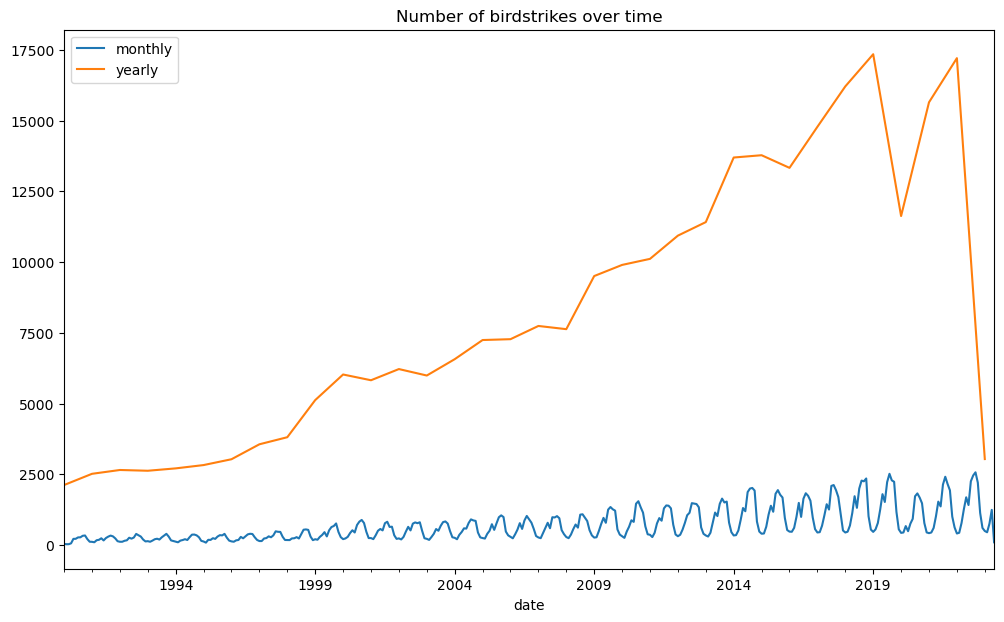

In [169]:
plt.figure(figsize=(12,7))
# df.resample('D').aircraft.count().plot(label='daily')
df.resample('M').aircraft.count().plot(label='monthly')
df.resample('Y').aircraft.count().plot(label='yearly')
plt.legend()
plt.title('Number of birdstrikes over time')
plt.show()

In [170]:
df.damage_level.value_counts()

N     163004
U      97412
M       8549
M?      6659
S       4236
D         82
Name: damage_level, dtype: int64

<AxesSubplot:xlabel='damage_level', ylabel='Count'>

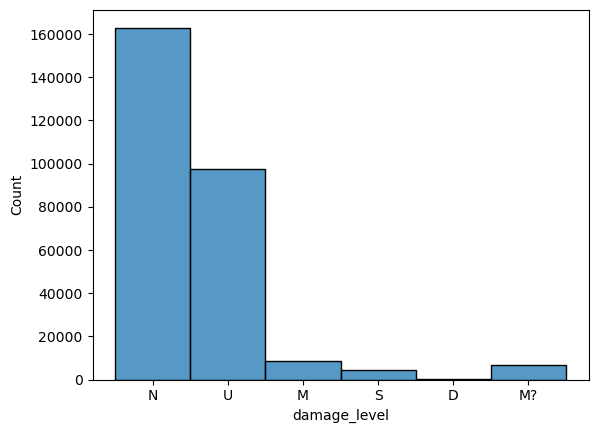

In [171]:
sns.histplot(data=df.damage_level)

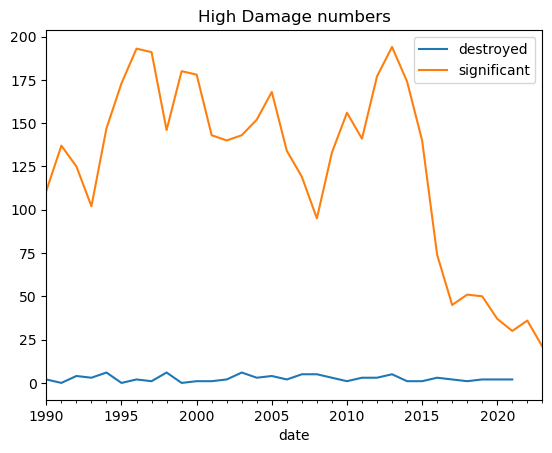

In [172]:
df[df.damage_level.str.contains('D')].resample('Y').aircraft.count().plot(label='destroyed')
df[df.damage_level.str.contains('S')].resample('Y').aircraft.count().plot(label='significant')
plt.legend()
plt.title('High Damage numbers')
plt.show()

<AxesSubplot:xlabel='date'>

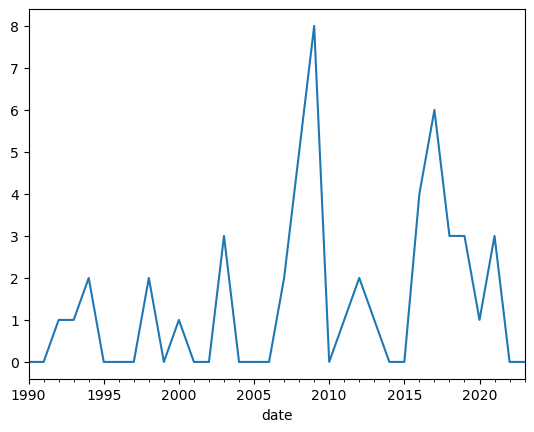

In [173]:
df.resample('Y').nr_fatalities.sum().plot()

<AxesSubplot:xlabel='date'>

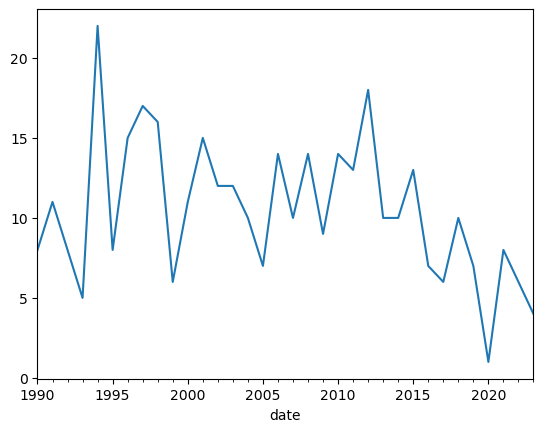

In [174]:
df.resample('Y').nr_injuries.sum().plot()

<AxesSubplot:xlabel='size_of_species', ylabel='Count'>

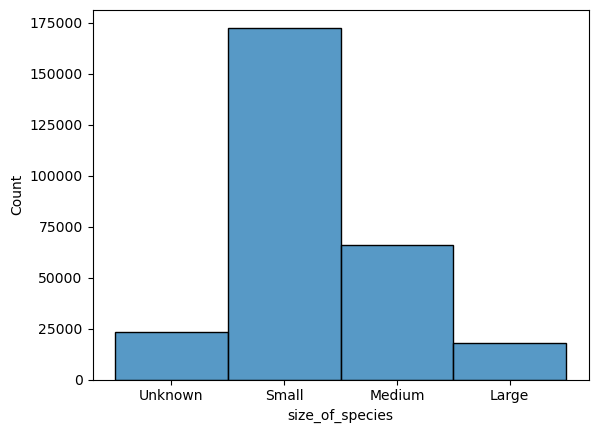

In [176]:
sns.histplot(data=df.size_of_species)

<AxesSubplot:xlabel='time_of_day', ylabel='Count'>

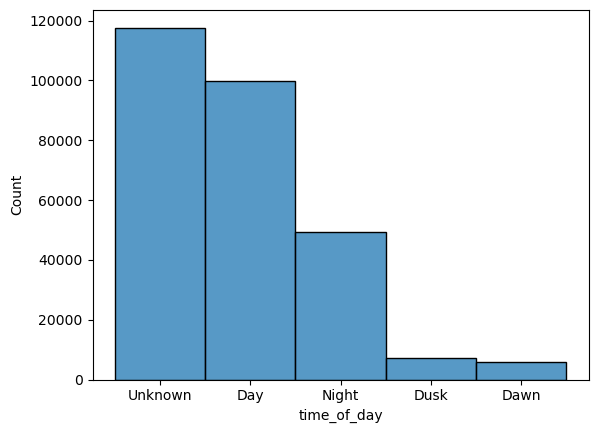

In [178]:
sns.histplot(data=df.time_of_day)

In [181]:
df.airport_id.value_counts()

ZZZZ    34302
KDEN     9260
KDFW     7527
KORD     6065
KJFK     5882
        ...  
T40         1
LIRP        1
KTLR        1
OI65        1
PALP        1
Name: airport_id, Length: 2591, dtype: int64

In [195]:
df = w.wrangle_wildlife_strike_df()

In [196]:
df.head()

,time_of_day,airport_id,airport,runway,state,opid,operator,aircraft,ac_class,ac_mass,type_eng,num_engs,phase_of_flight,precipitation,damage_level,species_id,species,size_of_species,nr_injuries,nr_fatalities
date,,,,,,,,,,,,,,,,,,,,
1990-01-02,Unknown,KJFK,JOHN F KENNEDY INTL,31L,NY,FDX,FEDEX EXPRESS,DC-10,A,4,D,3,Departure,Unknown,N,UNKB,Unknown bird,Unknown,0,0
1990-01-02,Unknown,PHLI,LIHUE ARPT,99,HI,UNK,UNKNOWN,UNKNOWN,Z,0,Z,-1,Unknown,Unknown,N,R1101,Barn owl,Small,0,0
1990-01-04,Unknown,PHLI,LIHUE ARPT,99,HI,HAL,HAWAIIAN AIR,DC-9,A,4,D,2,Landing Roll,Unknown,N,ZY1,Munias,Small,0,0
1990-01-05,Unknown,PHLI,LIHUE ARPT,99,HI,UNK,UNKNOWN,UNKNOWN,Z,0,Z,-1,Unknown,Unknown,N,N5122,Pacific golden-plover,Small,0,0
1990-01-05,Unknown,PHLI,LIHUE ARPT,99,HI,UNK,UNKNOWN,UNKNOWN,Z,0,Z,-1,Unknown,Unknown,N,ZY1,Munias,Small,0,0


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 279942 entries, 1990-01-02 to 2023-05-17
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   time_of_day      279942 non-null  object
 1   airport_id       279942 non-null  object
 2   airport          279942 non-null  object
 3   runway           279942 non-null  object
 4   state            279942 non-null  object
 5   opid             279942 non-null  object
 6   operator         279942 non-null  object
 7   aircraft         279942 non-null  object
 8   ac_class         279942 non-null  object
 9   ac_mass          279942 non-null  int64 
 10  type_eng         279942 non-null  object
 11  num_engs         279942 non-null  int64 
 12  phase_of_flight  279942 non-null  object
 13  precipitation    279942 non-null  object
 14  damage_level     279942 non-null  object
 15  species_id       279942 non-null  object
 16  species          279942 non-null  object

# BOTTOM LINE ON BOTTOM:
- My target will be damage level. This will be a classification project
    - (may be difficult since I'll essentially be trying to predict outliers)
- categories will be 
    - D - Aircraft Destroyed
    - S - Substantial Damage
    - M - Minor Damage
    - N - Negligible consisting of these values from the original database
        - N - None
        - U - Unknown (nulls)
        - M? - Undetermined level (per database)
